In [107]:
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import dataLoader as dl

#from Inner_Speech_Dataset.Plotting.ERPs import 
from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Calculate_power_windowed
from Inner_Speech_Dataset.Python_Processing.Utilitys import picks_from_channels


In [25]:
#Loading the data and labels from EEG and EXG
 
data1, labels1 = dl.load_data(datatype="EEG", subject_nr=1, verbose=True,sampling_rate=32) 
#data2, labels2 = dl.load_data(datatype="EEG", subject_nr=2 ,verbose=True) 
#data4 , labels4 = dl.load_data(datatype="EEG", subject_nr=4, verbose=True) 

dataX, labelsX = dl.load_data(datatype="EXG", verbose=False) 
datab, labelsb = dl.load_data(datatype="baseline", verbose=False) 
#dl.load_data(datatype2=2) #4.5 is max

#data = np.concatenate([data1, data2, data4], axis = 0)
#labels1d = np.concatenate([labels1, labels2, labels4], axis = 0)
data = data1
labels1d = labels1
labels = np.zeros([labels1d.shape[0], 2])
for row, label in enumerate(labels1d,0):
    if label == 0:
        labels[row,0] = 1
    if label == 1:
        labels[row,1] = 1

Data shape: [trials x channels x samples]
(500, 128, 160)
Labels shape
(500, 4)
Final data shape
(100, 128, 160)
Final labels shape
(100,)
Up is 0.0 and Down is 1.0
Up is 0.0 and Down is 1.0


In [108]:
picks_from_channels("OPZ")

['A17', 'A30', 'A20', 'A21', 'A22']

In [106]:

def get_power_array(split_data ,trialSplit = 2, samplingRate=32):

    #trialSplit = 16
    sR = samplingRate #samplingRate = 32
    data_power = np.zeros([split_data.shape[0], split_data.shape[1], trialSplit, 2])
    for t, trial in enumerate(split_data,0):
        for c, channel in enumerate(trial,0):
            for x in range(trialSplit):
                data_power[t, c, x, : ] = Calculate_power_windowed(channel, fc=sR, window_len=1*4/trialSplit, window_step=1*4/trialSplit, t_min=0, t_max=4/trialSplit * x + 4/trialSplit)
    

    #m_power , std_power
    print(data_power.shape)
    return data_power
    
data_p =  get_power_array(data)
print(data_p.shape)

(100, 128, 2, 2)
(100, 128, 2, 2)


In [19]:
#Splitting into training and test data
#print(labels)


order = np.arange(labels.shape[0])
np.random.shuffle(order)

temp_data = np.zeros(data.shape)
temp_labels = np.zeros(labels.shape)

for x in range(labels.shape[0]):
    i = order[x]
    
    temp_data[x] = data[i]
    temp_labels[x] = labels[i]

data = temp_data
labels = temp_labels

data_train, data_test = np.split(data, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
labels_train, labels_test = np.split(labels, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
print(labels_train.shape)
print(data_test.shape)

print(labels)



(75, 2)
(25, 128, 160)
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [20]:
#Convolution part

# Do the convs like I wrote in the Note
# First need to find out 8 best channels
#  Utilities can help average similar channels
# Read through article and how they did it better!
convlayer = tf.keras.layers.Conv2D(4,
 kernel_size=[2,1], input_shape= (data_train.shape[0], data_train.shape[1] , data_train.shape[2], 1,), 
 padding="valid", strides=[round(data_train.shape[1]),1],
 activation="relu")


print(data_train.shape)
print(data_test.shape)

#data_train = np.swapaxes(data_train, 2, 1)
#data_test = np.swapaxes(data_test, 2, 1)
print(data_train.shape)
print(data_test.shape)
data_train = np.expand_dims(data_train, axis=0)
data_test = np.expand_dims(data_test, axis=0)
data_train = np.moveaxis(data_train, 0, -1)
data_test = np.moveaxis(data_test, 0, -1)

conv_data_train = convlayer(data_train)
conv_data_test = convlayer(data_test)

data_train = conv_data_train
data_test = conv_data_test

#data_train = np.swapaxes(data_train, 2, 1)
#data_test = np.swapaxes(data_test, 2, 1)


data_train = np.squeeze(np.moveaxis(data_train, -1, 0))
data_test = np.squeeze(np.moveaxis(data_test, -1, 0))
print(data_train.shape)
print(data_test.shape)

(75, 128, 160)
(25, 128, 160)
(75, 128, 160)
(25, 128, 160)
(5, 75, 160)
(5, 25, 160)


In [21]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.clear_session()





eeg_model = tf.keras.Sequential([
    layers.Dense(input_shape = (data_train.shape[1],data_train.shape[2]), units=1024, activation="relu"),
    layers.Dropout(0.05),
    layers.Dense(units=1024, activation="relu"),
    layers.Dropout(0.05),
    layers.Dense(units=512, activation="relu"),
    layers.Dropout(0.05),
    layers.Flatten(input_shape = (16,512)),
    layers.Dense(units=2, activation="softmax")


])
eeg_model.build()
eeg_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 75, 1024)          164864    
                                                                 
 dropout (Dropout)           (None, 75, 1024)          0         
                                                                 
 dense_1 (Dense)             (None, 75, 1024)          1049600   
                                                                 
 dropout_1 (Dropout)         (None, 75, 1024)          0         
                                                                 
 dense_2 (Dense)             (None, 75, 512)           524800    
                                                                 
 dropout_2 (Dropout)         (None, 75, 512)           0         
                                                                 
 flatten (Flatten)           (None, 38400)             0

In [22]:
for trialNr, trial in enumerate(data_train[44:46],44):
    for channel in trial[5:6]:
        plt.figure()
        plt.plot(channel)
        plt.title("EEG {}".format(labels_train[trialNr]))

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, )

eeg_model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

eeg_model.fit(data_train, labels_train, callbacks=[callback],epochs=100, )

print("Results")
eeg_model.evaluate(data_test, labels_test)
result = eeg_model.predict(data_test)


ValueError: Data cardinality is ambiguous:
  x sizes: 5
  y sizes: 75
Make sure all arrays contain the same number of samples.

In [ ]:
result2 = []
print(result)
for res in result:
    x = np.maximum(res[0], res[1])
    result2.append(int(np.where(res == x)[0]))

result2 = np.array(result2)
print(result2)

[[0.5254448  0.47455516]
 [0.525445   0.47455502]
 [0.5254449  0.47455508]
 [0.5254448  0.47455516]
 [0.52544516 0.4745548 ]
 [0.52544504 0.474555  ]
 [0.5254445  0.4745555 ]
 [0.5254445  0.47455543]
 [0.52544504 0.47455496]
 [0.5254448  0.4745551 ]
 [0.52544475 0.47455522]
 [0.5254452  0.4745548 ]
 [0.52544475 0.4745552 ]
 [0.52544487 0.47455513]
 [0.5254451  0.47455484]
 [0.5254453  0.47455472]
 [0.5254449  0.4745551 ]
 [0.5254445  0.47455546]
 [0.52544475 0.47455525]
 [0.52544504 0.474555  ]
 [0.5254441  0.4745559 ]
 [0.52544504 0.474555  ]
 [0.5254449  0.4745551 ]
 [0.52544427 0.47455576]
 [0.52544504 0.47455493]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


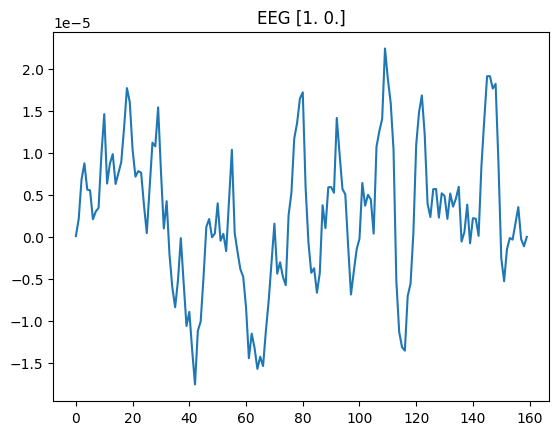

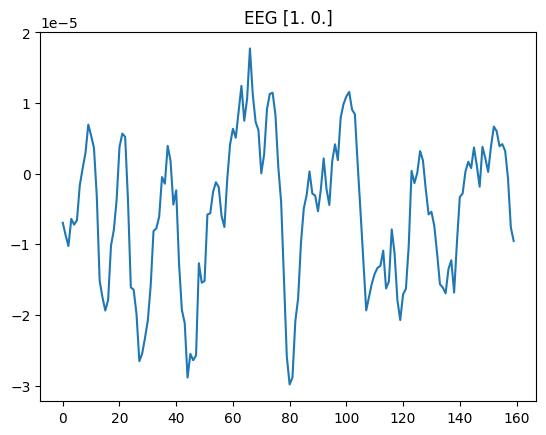

In [ ]:


for trialNr, trial in enumerate(data[44:46],44):
    for channel in trial[5:6]:
        plt.figure()
        plt.plot(channel)
        plt.title("EEG {}".format(labels[trialNr]))

      